# Section Linear Programming 

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pulp

     |████████████████████████████████| 40.6MB 109kB/s 


In [3]:
import networkx as nx
import pulp
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from tqdm.notebook import tqdm as pb
import sys
import pylab 
pylab.rcParams['figure.figsize'] = (10, 10)

## Data

In [ ]:
#Parser de fichiers
df = pd.read_csv("drive/My Drive/Colab Notebooks/data.txt",header=None)
M = df.values
df.head()

0      1      2   3
0  0 -11.03 -82.33  46
1  1  -4.93 -98.05  96
2  2  81.52   2.41  49
3  3  36.82 -42.62  71
4  4 -69.86  11.88  27

## Functions

In [ ]:
def plot_points(M, s, color=[], grid=True):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
    if len(color) == 0:
        scat = ax.scatter(M[:,1], M[:,2],s=s*M[:,3])
    else:
        scat = ax.scatter(M[:,1], M[:,2],s=s*M[:,3], c=color)
    if grid:
        major_ticks = np.arange(-100, 101, 25)
        minor_ticks = np.arange(-100, 101, 5)
        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(major_ticks)
        ax.set_yticks(minor_ticks, minor=True)
        ax.grid(which='both')
        
    plt.show()

In [ ]:
def get_sub_section(M, coord1, coord2):
    indices = []
    for i in range(M.shape[0]):
        if M[i,1] >= coord1[0] and M[i,1] <= coord2[0] and M[i, 2] >= coord1[1] and M[i, 2] <= coord2[1]:
            indices.append(i)
    # colors
    colors = np.zeros((M.shape[0]))
    for i in indices:
        colors[i] = 1
    return np.copy(M)[indices,:], colors

In [ ]:
M_sub, colors = get_sub_section(M, (0.,0.), (10.,10.))
M_sub.shape

(29, 4)

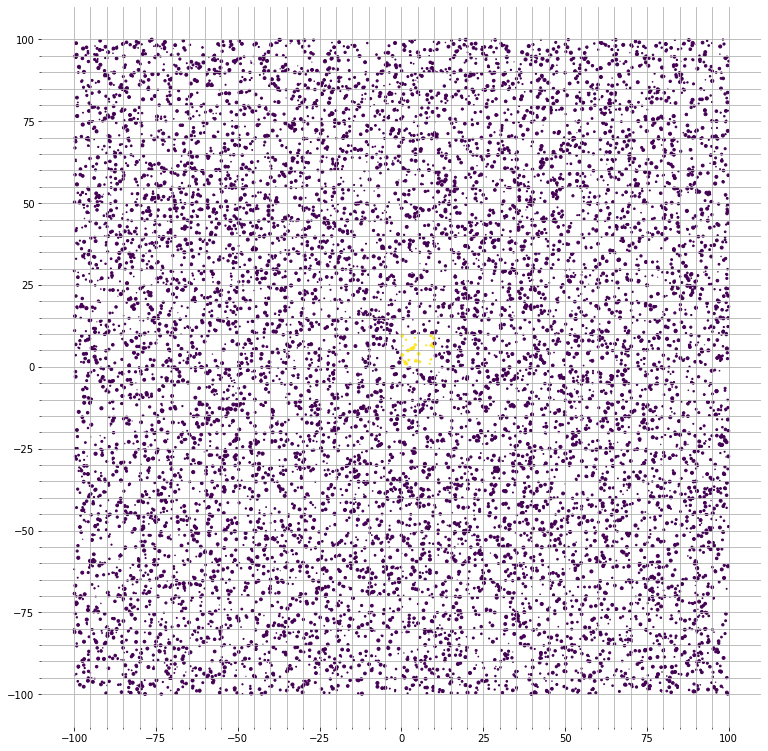

In [ ]:
plot_points(M, 0.1, colors)

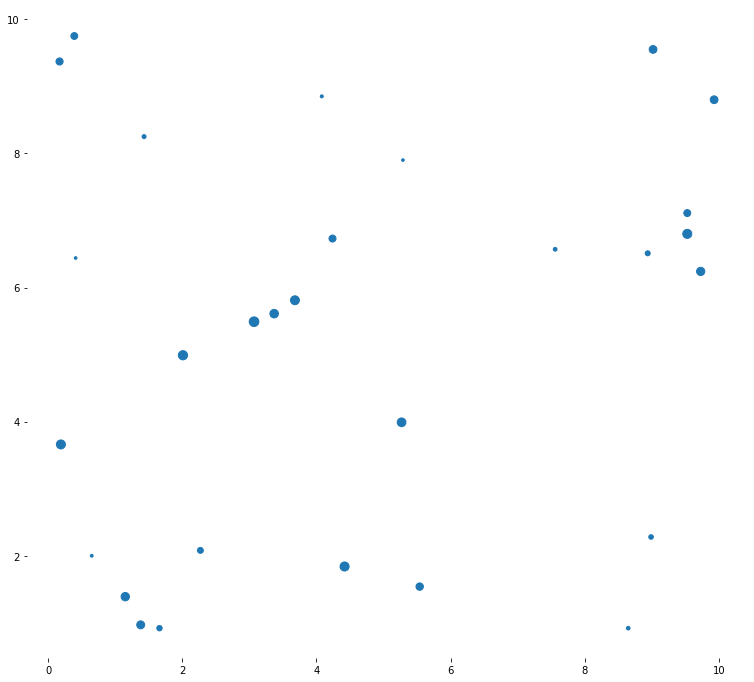

In [ ]:
plot_points(M_sub, 1, grid=False)

In [4]:
class SubSections():
    def __init__(self, M, slice_size, knn=-1):
        self.data = M
        self.knn = knn
        self.n = int(200./slice_size)
        self.slice_size = slice_size
        self.sections_vertices = self._get_all_sub_sections_vertices(M)
        self.sections_edges = self._get_all_sub_sections_edges(M)
        self.visited = [[False for _ in range(self.n)] for _ in range(self.n)]
    
    # Create all subsection from a plot
    def _get_all_sub_sections_vertices(self, M):
        sub_sections = [[0 for _ in range(self.n)] for _ in range(self.n)]
        for i in range(self.n):
            for j in range(self.n):
                sub_sections[i][j] = self._get_sub_section(M, (-100+i*self.slice_size,-100+j*self.slice_size), (-100+(i+1)*self.slice_size,-100+(j+1)*self.slice_size))
        return sub_sections

    # get subsection with coordinates
    def _get_sub_section(self, M, coord1, coord2):
        indices = []
        for i in range(M.shape[0]):
            if M[i,1] >= coord1[0] and M[i,1] <= coord2[0] and M[i, 2] >= coord1[1] and M[i, 2] <= coord2[1]:
                indices.append(i)
        return np.copy(M)[indices,:]

    # Create all subsection edges
    def _get_all_sub_sections_edges(self, M):
        sections_edges = [[0 for _ in range(self.n)] for _ in range(self.n)]
        for i in range(self.n):
            for j in range(self.n):
                sections_edges[i][j] = self._create_distance_edges(self.sections_vertices[i][j])
        return sections_edges
    
    # Compute all edges list and distances
    def _create_distance_edges(self, M):
        dim = M.shape[0]
        edges_dist = {}
        edges_list = []
        for i in range(dim):
            temp = np.zeros((dim))
            for j in range(dim):
                temp[j] = math.sqrt((M[i,1] - M[j,1])**2 + (M[i,2] - M[j,2])**2)
                
            if self.knn == -1:
                for j in range(dim):
                    if i != j:
                        edges_list.append((i, j))
                        edges_list.append((j, i))
                        edges_dist[i, j] = temp[j]
                        edges_dist[j, i] = temp[j]
            else:
                min_dist = np.argsort(temp)
                for j in range(1,min(self.knn+1, dim)):
                    to = min_dist[j]
                    edges_list.append((i, to))
                    edges_list.append((to, i))
                    edges_dist[i, to] = temp[to]
                    edges_dist[to, i] = temp[to]
                    
        return [edges_dist, edges_list, dim]

    # Find the next sub_section to visit
    def around_sub_sections(self, section):
        center = ((-100+section[0]*self.slice_size + -100 + (section[0]+1)*self.slice_size) /2,(-100 + section[1]*self.slice_size + -100 + (section[1]+1)*self.slice_size)/2)
        around_grid = np.zeros((self.n,self.n, 2))
        max_i_j = (-1,-1)
        max_score = -1
        for i in range(self.n):
            for j in range(self.n):
                if i != section[0] or j != section[1]:
                    if self.sections_vertices[i][j].shape[0] != 0:
                        around_grid[i,j, 0] = abs(section[0]-i)+abs(section[1]-j)
                        around_grid[i,j, 1] = np.sum(self.sections_vertices[i][j][:,3])
        
        for i in range(self.n):
            for j in range(self.n):
                if i != section[0] or j != section[1]:
                    if self.sections_vertices[i][j].shape[0] != 0:
                        center_section = ((-100+i*self.slice_size + -100 + (i+1)*self.slice_size) /2,(-100 + j*self.slice_size + -100 + (j+1)*self.slice_size)/2)
                        if i-1 >= 0:
                            if self.sections_vertices[i-1][j].shape[0] != 0:
                                around_grid[i,j,1] += 0.2*np.sum(self.sections_vertices[i-1][j][:,3])
                        if j-1 >= 0:
                            if self.sections_vertices[i][j-1].shape[0] != 0:
                                around_grid[i,j,1] += 0.2*np.sum(self.sections_vertices[i][j-1][:,3])
                        if j+1 < self.n:
                            if self.sections_vertices[i][j+1].shape[0] != 0:
                                around_grid[i,j,1] += 0.2*np.sum(self.sections_vertices[i][j+1][:,3])
                        if i+1 < self.n:
                            if self.sections_vertices[i+1][j].shape[0] != 0:
                                around_grid[i,j,1] += 0.2*np.sum(self.sections_vertices[i+1][j][:,3])
                        around_grid[i,j,1] = around_grid[i,j,1] / math.sqrt((center[0]-center_section[0])**2 + (center[1]-center_section[1])**2)
                        if around_grid[i,j,1] > max_score:
                            max_score = around_grid[i,j,1]
                            max_i_j = (i,j)
        return max_i_j

    # Separate the result of the ILP solving and finds Path, Cycles
    def _get_solution_and_add_constraints(self, G, edge_activation, edge_distances, source, target):
        validated = []
        correct = []
        actual_node = source
        sum_real = 0
        edges_choosen = [[] for i in range(len(G.nodes))]
        for i,j in G.edges:
            if edge_activation[i,j].value() == 1.0:
                edges_choosen[i].append(j)
        while actual_node != target:
            if len(edges_choosen[actual_node]) != 1:
                print(actual_node, edges_choosen[actual_node])
                print("error")
            else:
                correct.append(actual_node)
                next_ = edges_choosen[actual_node][0]
                validated.append((actual_node,next_))
                sum_real += edge_distances[actual_node,next_]
                actual_node = next_
        correct.append(actual_node)
        # detect cycle and will delete one of the edges
        cycles = []
        memory = []
        for i in range(len(edges_choosen)):
            if i not in correct and i not in memory and len(edges_choosen[i]) != 0:
                temp = []
                final_node = i
                temp.append(final_node)
                final_node = edges_choosen[final_node][0]
                while final_node != i:
                    next_ = edges_choosen[final_node][0]
                    temp.append(final_node)
                    final_node = next_
                memory += temp
                cycles.append(temp)
        # select first edge of each cycles and will add it to the future constraint
        return cycles, validated, sum_real

    # ILP Solver
    def _optimize(self, edges_dist, edges_list, max_pair, dim, _max_time, init_rewards, cycle_constraint):
        rewards = np.append(init_rewards, 0)
        # Source and target
        source = max_pair[0]
        target = max_pair[1]

        update_constraints = cycle_constraint
        loop = True
        iteration = 0
        while loop:
            # Create the Graph
            G = nx.DiGraph()
            # add nodes
            for i in range(dim):
                G.add_node(i)
            # add edges
            G.add_edges_from(edges_list)
            nx.set_edge_attributes(G, edges_dist, 'weight')
            # Non changing parameters
            edge_distances = nx.get_edge_attributes(G, 'weight')
            
            # instantiate
            prob = pulp.LpProblem("MaxRewardInLimitedTime", pulp.LpMaximize)
            # binary variable to state a link is chosen or not
            edge_activation = {}

            
            vertices = [[] for i in range(dim)]
            vertices
            for i, j in G.edges:
                x = pulp.LpVariable("activ(%s,%s)" % (i,j), cat=pulp.LpBinary)
                edge_activation[i, j] = x
                if i == source:
                    vertices[i].append(edge_activation[i, j])
                else:
                    vertices[j].append(edge_activation[i, j])

            vertices = [sum(vertices[i])*rewards[i] for i in range(dim)]
            
            # objective function
            prob += pulp.lpSum(vertices), "Total Hop Count"
            # constraints
            for node in G.nodes:
              if node == source:
                  prob += pulp.lpSum([edge_activation[i, k] for i, k in G.edges if k == node]) - \
                        pulp.lpSum([edge_activation[k, j] for k, j in G.edges if k == node]) == -1
                  prob += pulp.lpSum([edge_activation[i, k] for i, k in G.edges if k == node]) == 0
              elif node == target:
                  prob += pulp.lpSum([edge_activation[i, k] for i, k in G.edges if k == node]) - \
                        pulp.lpSum([edge_activation[k, j] for k, j in G.edges if k == node]) == 1
                  prob += pulp.lpSum([edge_activation[k, j] for k, j in G.edges if k == node]) == 0
              else:   
                  prob += pulp.lpSum([edge_activation[i, k] for i, k in G.edges if k == node]) - \
                        pulp.lpSum([edge_activation[k, j] for k, j in G.edges if k == node]) == 0
                  prob += pulp.lpSum([edge_activation[i, k] for i, k in G.edges if k == node]) + \
                        pulp.lpSum([edge_activation[k, j] for k, j in G.edges if k == node]) <= 2
            # break previous cycles and hopefully will come over
            for cycle in update_constraints:
                vertices_nb = len(cycle)
                cycle_cons = [edge_activation[cycle[k-1], cycle[k]] for k in range(vertices_nb)]
                cycle_cons_inv = [edge_activation[cycle[k], cycle[k-1]] for k in range(vertices_nb)]

                prob += pulp.lpSum([cycle_cons]) <= vertices_nb-1
                prob += pulp.lpSum([cycle_cons_inv]) <= vertices_nb-1
                    
            
            # for each edge 
            for i, j in G.edges:
                try:
                    edge_activation[j, i]
                    prob += pulp.lpSum([edge_activation[i, j], edge_activation[j, i]]) <= 1
                except Exception:
                    pass
                    
            # inferior to max time
            prob += pulp.lpSum([edge_distances[i, j] * edge_activation[i, j] for i, j in G.edges]) <= _max_time
            
            # solve
            prob.solve()
            if prob.status != 1:
                # the time required is too low
                return self._optimize(edges_dist, edges_list, max_pair, dim, _max_time+1.0, init_rewards, update_constraints)

            cycles, path, sum_dist = self._get_solution_and_add_constraints(G, edge_activation, edge_distances, source, target)
            n = len(cycles)

            if n == 0:
                loop = False
            else:
                iteration += 1
                update_constraints += cycles
        return path, sum_dist, np.sum([rewards[i] for i,_ in path]+[rewards[path[-1][1]]]), update_constraints

    # Find the best point in the next subsection
    def _find_best_target(self, source, sec_choosen, points, new_M, max_time):
        best_li = []
        best_score = -10
        best_dist = 0
        best_target = -1
        # 
        all_cycle_constraints = []
        for k in range(len(points)):
            edges_dist = self.sections_edges[sec_choosen[0]][sec_choosen[1]][0].copy()
            edges_list = self.sections_edges[sec_choosen[0]][sec_choosen[1]][1].copy()
            M = np.copy(self.sections_vertices[sec_choosen[0]][sec_choosen[1]])
            # append new edges and point regarding to the current end point selected
            target = M.shape[0]
            init_distance = np.zeros((M.shape[0]))
            for i in range(M.shape[0]):
                init_distance[i] = math.sqrt((M[i,1] - new_M[points[k],1])**2 + (M[i,2] - new_M[points[k],2])**2)
            for i in range(M.shape[0]): 
                edges_list.append((i, target))
                edges_dist[i, target] = init_distance[i]
            M = np.append(M, np.array([np.copy(new_M[points[k]])]), axis=0)

            # optimize the problem wit lp solver
            path, dist, score, all_cycle_constraints = self._optimize(edges_dist, edges_list, (source, target), M.shape[0], max_time, M[:,3], all_cycle_constraints)

            if best_score < score:
                best_score = score
                best_dist = dist
                best_li = path
                best_target = k
        if len(points) == 0:
            print("No points available in this sub section")
        return best_li, best_score, best_dist, points[best_target]

    # Find the best point in the next subsection
    def _get_nearest_points_from_center_section(self, sec_choosen):
        # select the next section to visit
        next_sec = self.around_sub_sections(sec_choosen)
        # get the 3 nearest point in the next section from the actual center section
        center = ((-100+sec_choosen[0]*self.slice_size + -100 + (sec_choosen[0]+1)*self.slice_size) /2,(-100 + sec_choosen[1]*self.slice_size + -100 + (sec_choosen[1]+1)*self.slice_size)/2)
        new_M = self.sections_vertices[next_sec[0]][next_sec[1]]
        distances = np.zeros((new_M.shape[0]))
        for i in range(new_M.shape[0]):
            distances[i] = math.sqrt((new_M[i,1] - center[0])**2 + (new_M[i,2] - center[1])**2)
        return np.argsort(distances)[:3].tolist(), new_M, next_sec

    # execute the problem
    def execute(self, max_time):
        sub_section_time = 10.

        # ----------------------------- Initialization -------------------------------- #
        # select first sub_sections
        middle = int(self.n / 2)
        sec_choosen = (middle,middle)
        # add the init_coords and edges
        M = self.sections_vertices[sec_choosen[0]][sec_choosen[1]]
        init_distance = np.zeros((M.shape[0]))
        for i in range(M.shape[0]):
            init_distance[i] = math.sqrt((M[i,1] - 0.)**2 + (M[i,2] - 0.)**2)
        for i in range(M.shape[0]): 
            self.sections_edges[sec_choosen[0]][sec_choosen[1]][1].append((M.shape[0], i))
            self.sections_edges[sec_choosen[0]][sec_choosen[1]][0][M.shape[0], i] = init_distance[i]
        self.sections_vertices[sec_choosen[0]][sec_choosen[1]] = np.append(self.sections_vertices[sec_choosen[0]][sec_choosen[1]], np.array([[-1., 0., 0., 0.]]), axis=0)

        # select the next section to visit
        points, new_M, next_sec = self._get_nearest_points_from_center_section(sec_choosen)

        # for each points, find the best rewarding path from current section to next section
        vertices_seen = []
        total_time = 0.
        total_score = 0.

        source = self.sections_vertices[sec_choosen[0]][sec_choosen[1]].shape[0]-1
        path, score, distance, target_selected = self._find_best_target(source, sec_choosen, points, new_M, sub_section_time)
        # update game scoreboard
        li = [i for i,_ in path]
        M = self.sections_vertices[sec_choosen[0]][sec_choosen[1]]
        vertices_seen += [int(M[j,0]) for j in li][1:] + [int(new_M[target_selected, 0])]
        total_score += score
        total_time += distance

        # update environnement and subsections
        self.sections_vertices[sec_choosen[0]][sec_choosen[1]] = self.sections_vertices[sec_choosen[0]][sec_choosen[1]][[n not in li for n in range(self.sections_vertices[sec_choosen[0]][sec_choosen[1]].shape[0])]]
        self.sections_edges[sec_choosen[0]][sec_choosen[1]] = self._create_distance_edges(self.sections_vertices[sec_choosen[0]][sec_choosen[1]])
        self.sections_vertices[next_sec[0]][next_sec[1]][target_selected, 3] = 0.

        # next source is current target
        source = target_selected
        sec_choosen = next_sec

        # ----------------------------- Iteration -------------------------------- #
        iteration = 0
        while total_time < max_time:
            # keep track of scores
            sys.stdout.write("\rTotal Score = {}, Distance = {}             ".format(total_score, total_time))
            sys.stdout.flush()
            if iteration % 100 == 0:
                colors = [(1 if i in vertices_seen else 0) for i in range(self.data.shape[0])]
                plot_points(self.data, 0.1, colors)


            # select the next section to visit
            M = self.sections_vertices[sec_choosen[0]][sec_choosen[1]]
            points, new_M, next_sec = self._get_nearest_points_from_center_section(sec_choosen)

            path, score, distance, target_selected = self._find_best_target(source, sec_choosen, points, new_M, sub_section_time)

            # update game scoreboard
            li = [i for i,_ in path]
            M = self.sections_vertices[sec_choosen[0]][sec_choosen[1]]
            vertices_seen += [int(M[j,0]) for j in li][1:] + [int(new_M[target_selected, 0])]
            total_score += score
            total_time += distance

            # update environnement and subsections
            self.sections_vertices[sec_choosen[0]][sec_choosen[1]] = self.sections_vertices[sec_choosen[0]][sec_choosen[1]][[n not in li for n in range(self.sections_vertices[sec_choosen[0]][sec_choosen[1]].shape[0])]]
            self.sections_edges[sec_choosen[0]][sec_choosen[1]] = self._create_distance_edges(self.sections_vertices[sec_choosen[0]][sec_choosen[1]])
            self.sections_vertices[next_sec[0]][next_sec[1]][target_selected, 3] = 0.

            # next source is current target
            source = target_selected
            sec_choosen = next_sec
            iteration += 1
        return total_time, total_score, vertices_seen
            

## Processing

In [ ]:
grid = SubSections(M, 5, 3)

In [ ]:
_max_time = 10000.

Total Score = 429.0, Distance = 9.48148289268058             

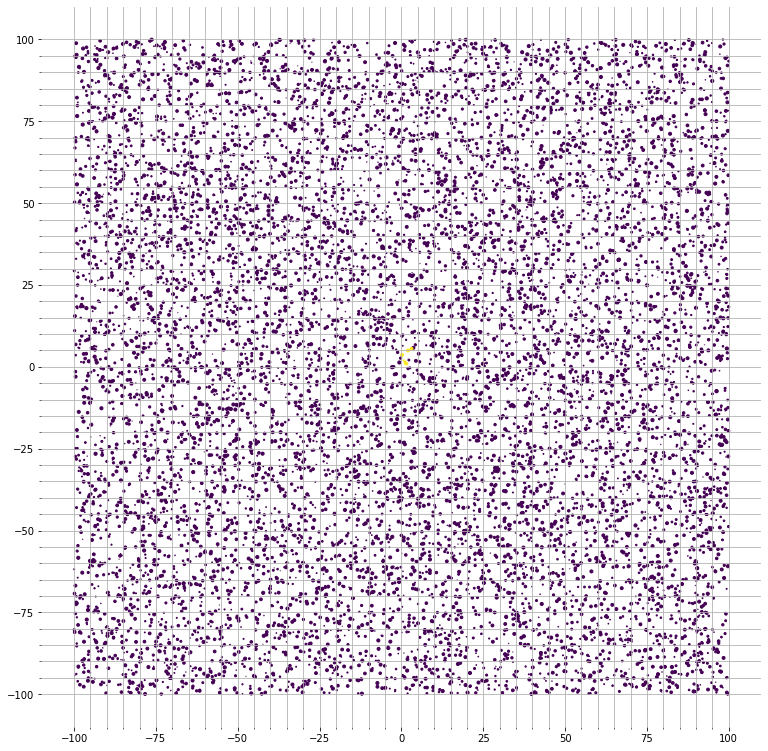

Total Score = 33202.0, Distance = 931.8605262979178             

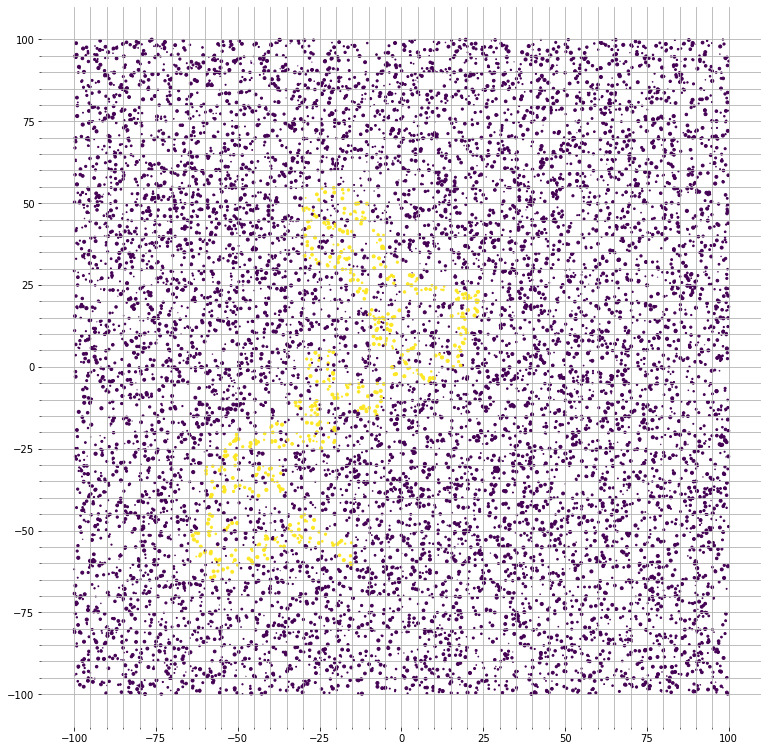

Total Score = 62577.0, Distance = 1846.8996451566243             

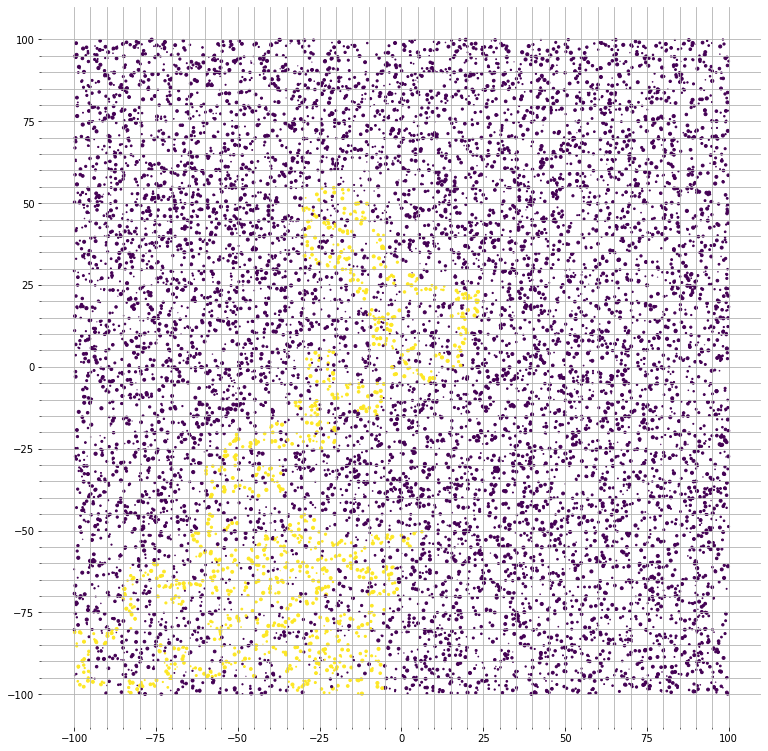

Total Score = 95807.0, Distance = 2768.6314916511737             

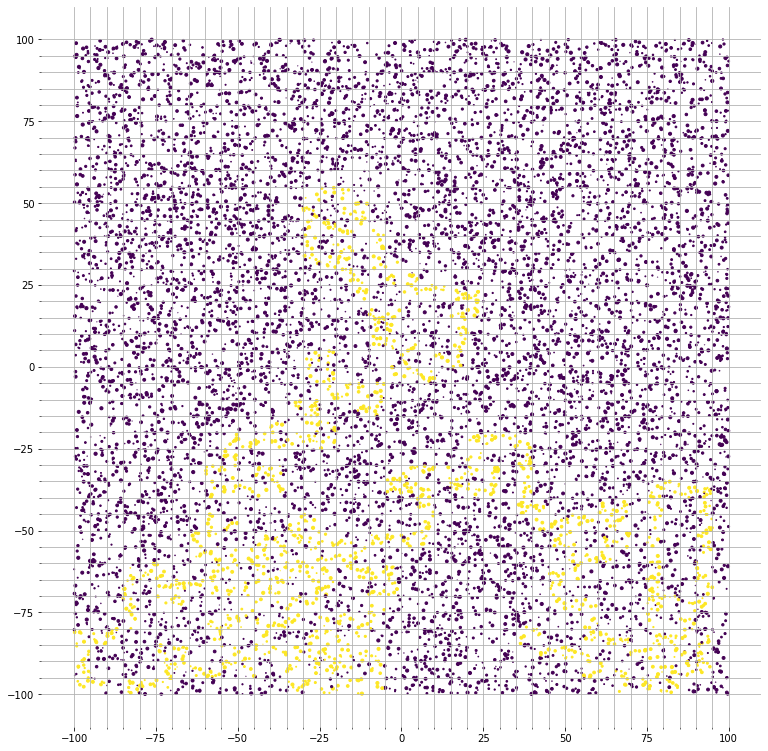

Total Score = 128122.0, Distance = 3689.160366578887             

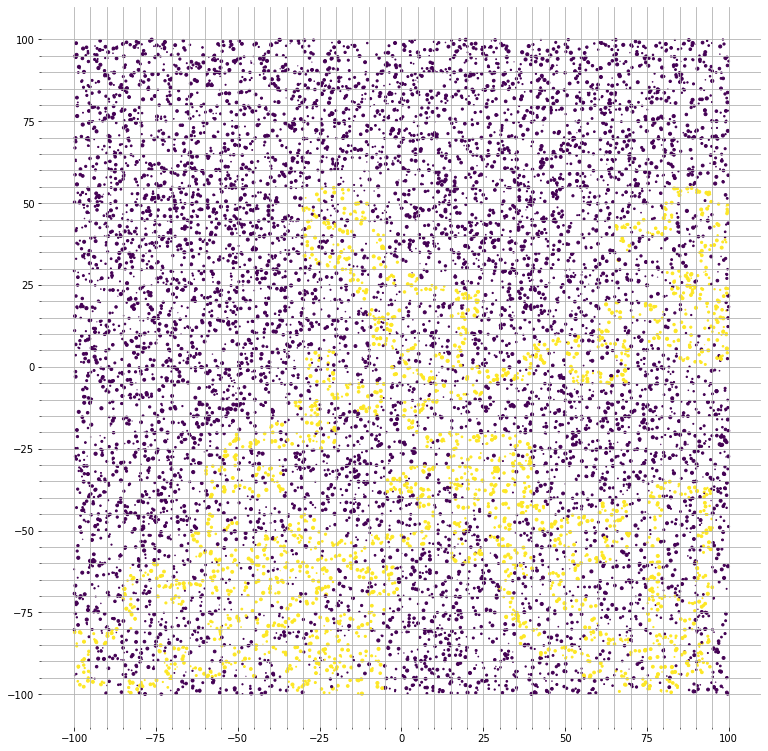

Total Score = 161398.0, Distance = 4633.455308325837             

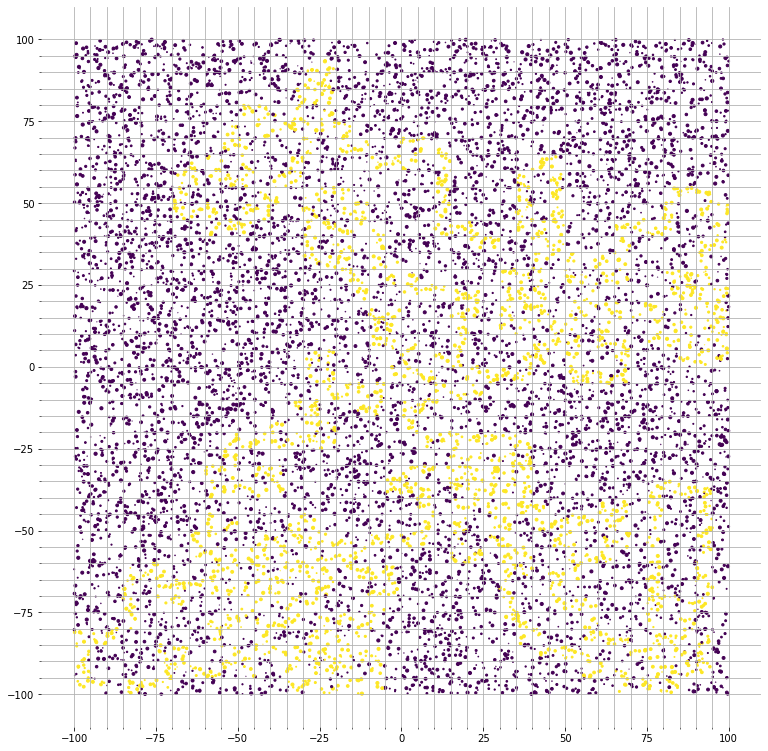

Total Score = 189432.0, Distance = 5556.194137393379             

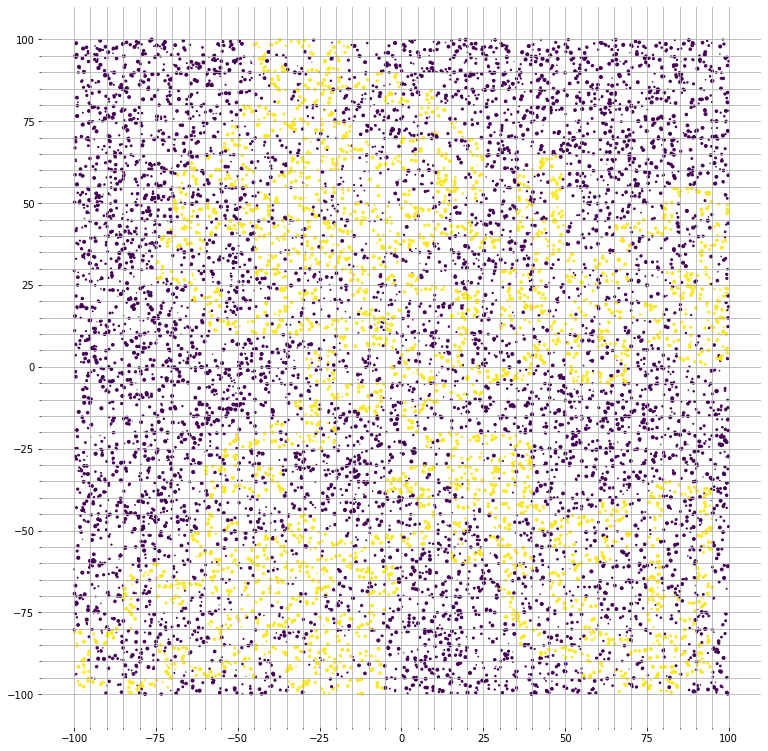

Total Score = 214337.0, Distance = 6476.0307845980515             

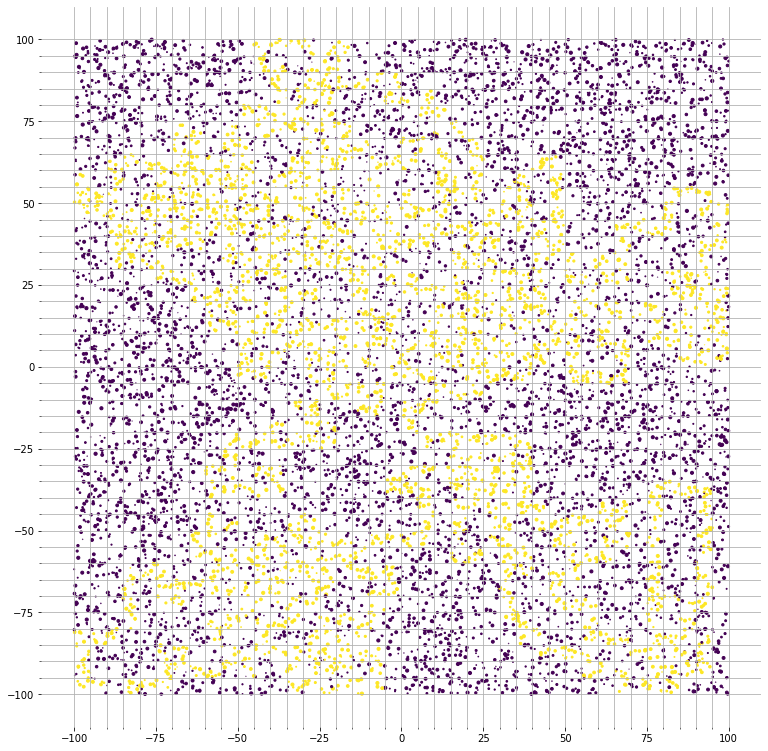

Total Score = 241292.0, Distance = 7375.768887232118             

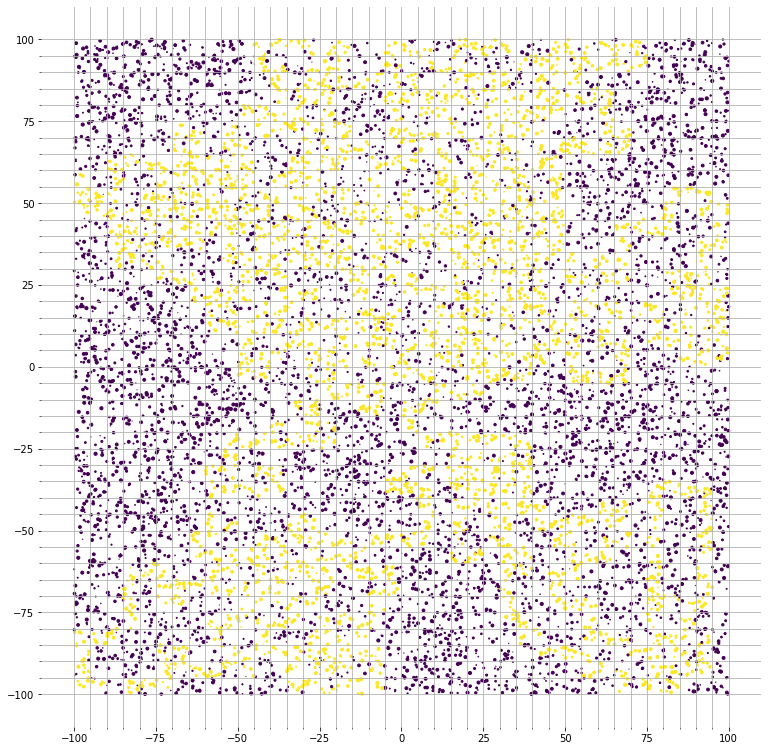

Total Score = 264200.0, Distance = 8289.850581614664             

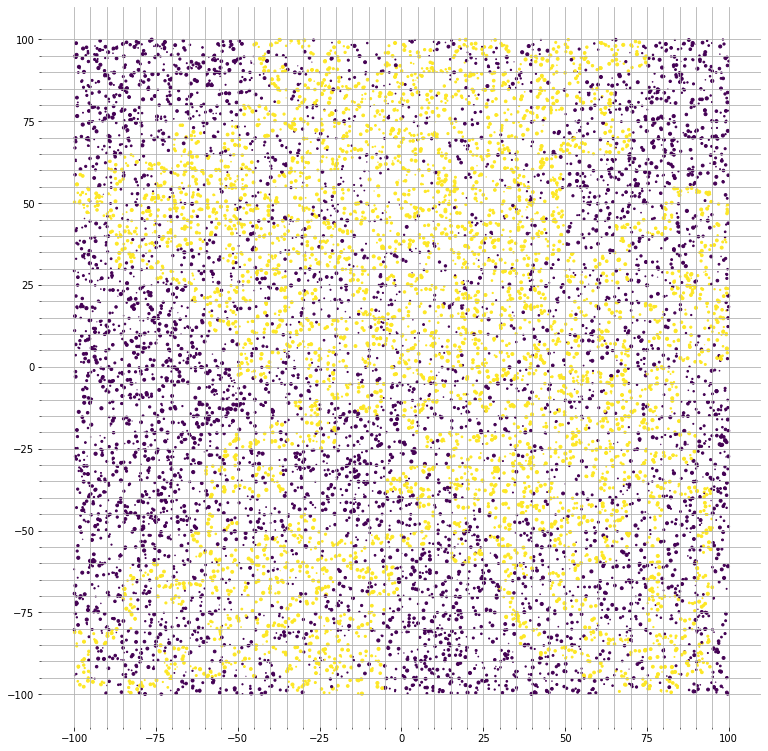

Total Score = 288568.0, Distance = 9204.47456225788             

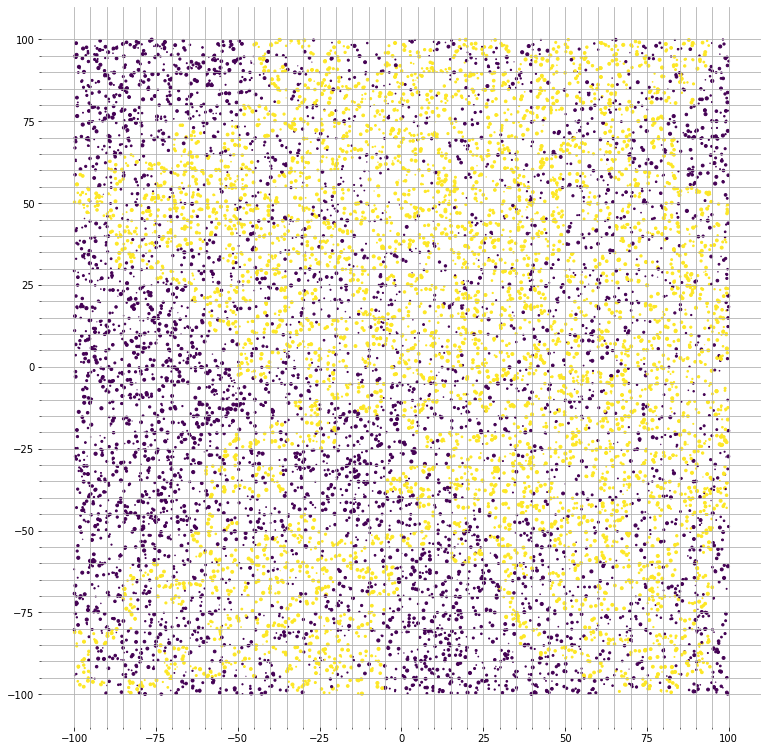

Total Score = 308048.0, Distance = 9997.794207914698             

In [ ]:
_time,_score,li = grid.execute(_max_time)


In [ ]:
print(_time,_score)

10007.625053595948 308237.0
